# Computing performance measures (test-section-wise)

In [90]:
from configparser import ConfigParser
from sqlalchemy import create_engine
import pandas as pd
from ua_parser import user_agent_parser
from geolite2 import geolite2
import geopandas as gpd
import pycountry
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(color_codes=True)
sns.set_palette('autumn')
from pandas.api.types import is_numeric_dtype

import numpy as np

def read_db_config(filename='config-dump.ini', section='mysql'):
    """ Read database configuration file and return a dictionary object
    :param filename: name of the configuration file
    :param section: section of database configuration
    :return: a dictionary of database parameters
    """
    # create parser and read ini configuration file
    parser = ConfigParser()
    parser.read(filename)
 
    # get section, default to mysql
    db = {}
    if parser.has_section(section):
        items = parser.items(section)
        for item in items:
            db[item[0]] = item[1]
    else:
        raise Exception('{0} not found in the {1} file'.format(section, filename))
 
    return db

dbconfig = read_db_config()
CONN = 'mysql+mysqlconnector://'+dbconfig['user']+':'+dbconfig['pwd']+'@'+dbconfig['host']+':'+dbconfig['port'] + '/'+dbconfig['dbname']
engine = create_engine(CONN)

In [2]:
## For each (valid) test section compute and add the following fields to MySQL table VALID_TEST_SECTIONS: 
### TS_WPM : computed wpm. Check: chould be equal to WPM
### TS_ED : computed edit distance (uncorrected error). Check: chould be equal to ERROR_RATE
### TS_BSP : backspaces per sentence (in a given test section)
### TS_ECPC : error corrections per character (in a given test section)
### TS_KSPC : keystrokes per character (in a given test section)
### TS_IKI : average inter-keystroke interval (in a given test section)
### TS_KPD : average key press duration (in a given test section)
### TS_SWYPE : detected swype (0|1) or average
### TS_AUTOC : detected autocorrection (0|1) or average
### TS_PRED : detected prediction (0|1) or average

## TS_KPD

In [ ]:
"""
# ALTER TABLE KEYSTROKES ADD KPD INT AS (RELEASE_TIME-PRESS_TIME)
ALTER TABLE VALID_TEST_SECTIONS ADD COLUMN TS_KPD DOUBLE; 

UPDATE VALID_TEST_SECTIONS ts
set TS_KPD=(
    SELECT AVG(k.RELEASE_TIME - k.PRESS_TIME)
    from KEYSTROKES k
    where k.TEST_SECTION_ID = ts.TEST_SECTION_ID
)
"""



## TS_IKI

In [ ]:
"""
ALTER TABLE VALID_TEST_SECTIONS ADD COLUMN TS_IKI DOUBLE; 

UPDATE VALID_TEST_SECTIONS ts
set TS_IKI=(
    SELECT AVG(k.IKI)
    from KEYSTROKES k
    where k.TEST_SECTION_ID = ts.TEST_SECTION_ID
)
"""

# 14:40 - 14:43 -> 3 min

## TS_BSP

In [ ]:
"""
ALTER TABLE VALID_TEST_SECTIONS ADD COLUMN TS_BSP DOUBLE; 

UPDATE VALID_TEST_SECTIONS ts
set TS_BSP =(
    SELECT COUNT(k.KEYSTROKE_ID)
    from KEYSTROKES k
    where k.TEST_SECTION_ID = ts.TEST_SECTION_ID
    AND k.LETTER = 'BKSP'
)
"""

# 14:54 - 14:57 -> 3 min

## TS_ECPC

In [ ]:
"""
ALTER TABLE VALID_TEST_SECTIONS ADD COLUMN TS_ECPC DOUBLE;

UPDATE VALID_TEST_SECTIONS ts
set TS_ECPC =(
     ts.TS_BSP / ts.INPUT_LENGTH
)
"""



## TS_UILEN 
#### (Length of the USER_INPUT field)

In [ ]:
"""
ALTER TABLE VALID_TEST_SECTIONS ADD COLUMN TS_UILEN INT; 

UPDATE VALID_TEST_SECTIONS
set TS_UILEN = LENGTH(USER_INPUT)

"""

#### Seems like INPUT_LENGTH already has -1 in it (in most of the cases, but not always): 
SELECT count(TEST_SECTION_ID)
from VALID_TEST_SECTIONS 
where INPUT_LENGTH = TS_UILEN

 ret. 3993
     

## TS_KS 
#### (Number of keystrokes per test section)

In [ ]:
"""
ALTER TABLE VALID_TEST_SECTIONS ADD COLUMN TS_KS INT; 

UPDATE VALID_TEST_SECTIONS ts
set TS_KS =(
    SELECT COUNT(k.KEYSTROKE_ID)
    from KEYSTROKES k
    where k.TEST_SECTION_ID = ts.TEST_SECTION_ID
)
"""

## TS_KSPC

In [ ]:
"""
ALTER TABLE VALID_TEST_SECTIONS ADD COLUMN TS_KSPC DOUBLE; 

UPDATE VALID_TEST_SECTIONS ts
set TS_KSPC =(
    ts.TS_KS / ts.TS_UILEN
)
"""



# Same for FIRST_15_TEST_SECTIONS (p.s. remove if exists)


In [50]:
"""
CREATE TABLE FIRST_15_TEST_SECTIONS LIKE VALID_TEST_SECTIONS;
INSERT INTO FIRST_15_TEST_SECTIONS
    SELECT * FROM VALID_TEST_SECTIONS
    WHERE TEST_SECTION_ID IN (
        SELECT TEST_SECTION_ID
            FROM (
                  SELECT  @type_number := IF(@PARTICIPANT_ID = PARTICIPANT_ID, @type_number + 1, 1) AS type_number, 
                          @PARTICIPANT_ID := PARTICIPANT_ID as PARTICIPANT_ID, 
                          TEST_SECTION_ID
                  FROM 
                      (SELECT @type_number := 1) x, 
                      (SELECT TEST_SECTION_ID, @PARTICIPANT_ID := PARTICIPANT_ID as PARTICIPANT_ID FROM VALID_TEST_SECTIONS ORDER BY PARTICIPANT_ID) y
                ) z
            WHERE type_number <= 15
    );

"""

''

## TS_WPM: TEST_SECTIONS.WPM be trusted? (what exactly is INPUT_TIME and INPUT_LENGTH?)

In [ ]:
"""
ALTER TABLE VALID_TEST_SECTIONS ADD COLUMN TS_WPM DOUBLE; 
"""

# If TEST_SECTIONS.WPM can be trusted:
"""
UPDATE VALID_TEST_SECTIONS ts
set TS_WPM =(
      (ts.INPUT_LENGTH / ts.INPUT_TIME) * 12 * 1000
)
"""

# Manual check (# If TEST_SECTIONS.WPM can't be trusted:):
# If test section starts with SHIFT - do not subtract 1
# If test section does not start with SHIFT - subrtact 1

"""
ALTER TABLE VALID_TEST_SECTIONS ADD COLUMN TS_SHIFT DOUBLE;
ALTER TABLE VALID_TEST_SECTIONS ADD COLUMN TS_FIRST_KS DOUBLE;
ALTER TABLE VALID_TEST_SECTIONS ADD COLUMN TS_FIRST_SHIFT DOUBLE;
ALTER TABLE VALID_TEST_SECTIONS ADD COLUMN TS_WPM DOUBLE; 
"""
"""
UPDATE VALID_TEST_SECTIONS ts
set TS_FIRST_SHIFT =( 
    SELECT MIN(k.KEYSTROKE_ID)
    from KEYSTROKES k
    where k.TEST_SECTION_ID = ts.TEST_SECTION_ID
    AND k.LETTER = 'SHIFT'
)

UPDATE VALID_TEST_SECTIONS ts
set TS_FIRST_KS =(
    SELECT MIN(k.KEYSTROKE_ID)
    from KEYSTROKES k
    where k.TEST_SECTION_ID = ts.TEST_SECTION_ID
)

UPDATE VALID_TEST_SECTIONS ts
set TS_SHIFT = 
    CASE WHEN ts.TS_FIRST_SHIFT = ts.TS_FIRST_KS THEN 1 ELSE 0 

"""
"""
UPDATE VALID_TEST_SECTIONS ts
set TS_WPM =(
      ( (ts.INPUT_LENGTH - ts.TS_SHIFT) / ts.INPUT_TIME) * 12 * 1000
)
"""



# Same metrics participant-wise (averaged over test sections in FIRST_15_TEST_SECTIONS)

In [ ]:
"""
ALTER TABLE VALID_PARTICIPANTS ADD COLUMN P_KPD DOUBLE; 
ALTER TABLE VALID_PARTICIPANTS ADD COLUMN P_IKI DOUBLE; 
ALTER TABLE VALID_PARTICIPANTS ADD COLUMN P_BSP DOUBLE; 
ALTER TABLE VALID_PARTICIPANTS ADD COLUMN P_ECPC DOUBLE; 
ALTER TABLE VALID_PARTICIPANTS ADD COLUMN P_UILEN DOUBLE; 
ALTER TABLE VALID_PARTICIPANTS ADD COLUMN P_KSPC DOUBLE; 


UPDATE VALID_PARTICIPANTS p
set P_KPD =(
    SELECT AVG(ts.TS_KPD)
    from FIRST_15_TEST_SECTIONS ts
    where ts.PARTICIPANT_ID = p.PARTICIPANT_ID
); 

UPDATE VALID_PARTICIPANTS p
set P_IKI =(
    SELECT AVG(ts.TS_IKI)
    from FIRST_15_TEST_SECTIONS ts
    where ts.PARTICIPANT_ID = p.PARTICIPANT_ID
); 

UPDATE VALID_PARTICIPANTS p
set P_BSP =(
    SELECT AVG(ts.TS_BSP)
    from FIRST_15_TEST_SECTIONS ts
    where ts.PARTICIPANT_ID = p.PARTICIPANT_ID
); 


UPDATE VALID_PARTICIPANTS p
set P_ECPC =(
    SELECT AVG(ts.TS_ECPC)
    from FIRST_15_TEST_SECTIONS ts
    where ts.PARTICIPANT_ID = p.PARTICIPANT_ID
); 


UPDATE VALID_PARTICIPANTS p
set P_UILEN =(
    SELECT AVG(ts.TS_UILEN)
    from FIRST_15_TEST_SECTIONS ts
    where ts.PARTICIPANT_ID = p.PARTICIPANT_ID
); 

UPDATE VALID_PARTICIPANTS p
set P_KSPC =(
    SELECT AVG(ts.TS_KSPC)
    from FIRST_15_TEST_SECTIONS ts
    where ts.PARTICIPANT_ID = p.PARTICIPANT_ID
);
"""

# Other (test) snippets

In [ ]:
SELECT ld.TEST_SECTION_ID, ld.DATA FROM LOG_DATA ld
WHERE ld.TEST_SECTION_ID IN (
    SELECT ts.TEST_SECTION_ID 
    FROM TEST_SECTIONS ts 
    WHERE PARTICIPANT_ID = 131010
) AND ld.TYPE ='input'



In [ ]:
SELECT ld.TEST_SECTION_ID, ld.DATA, SOUNDEX(ld.DATA)
from LOG_DATA ld
where ld.TEST_SECTION_ID IN (716616, 716618, 716621)  AND ld.TYPE ='input'

In [ ]:
select @prev:=ld.DATA 
from LOG_DATA ld 
where ld.TYPE = 'input' and ld.TEST_SECTION_ID IN (716616, 716618, 716621) ORDER BY ld.TEST_SECTION_ID, ld.LOG_DATA_ID 
ASC LIMIT 1,1;

select 
	ld.LOG_DATA_ID, 
	ld.TEST_SECTION_ID, 
	@prev, 
	ld.DATA, 
	levenshtein(ld.DATA, @prev) as LDIST,
	@prev:=ld.DATA
from LOG_DATA ld
where  ld.TYPE = 'input' and ld.TEST_SECTION_ID IN (716616, 716618, 716621) #and ld.DATA !=  ''

In [ ]:
"""
select @prev:=ld.DATA 
from LOG_DATA ld 
where ld.TYPE = 'input'
ORDER BY ld.TEST_SECTION_ID, ld.LOG_DATA_ID 
ASC LIMIT 1,1;

select 
    ld.LOG_DATA_ID, 
    ld.TEST_SECTION_ID, 
    @prev, 
    ld.DATA, 
    levenshtein(ld.DATA, @prev) as LDIST,
    @prev:=ld.DATA
from LOG_DATA ld
where ld.TYPE = 'input'
"""

In [ ]:
"""
ALTER TABLE VALID_TEST_SECTIONS ADD COLUMN TS_INTEL_SW INT;
ALTER TABLE VALID_TEST_SECTIONS ADD COLUMN TS_INTEL_AC INT;
ALTER TABLE VALID_TEST_SECTIONS ADD COLUMN TS_INTEL_PR INT;
"""
"""
UPDATE VALID_TEST_SECTIONS ts
set TS_INTEL_SW = (

    SELECT ld.TEST_SECTION_ID, ld.DATA
    from LOG_DATA ld
    where ld.TEST_SECTION_ID = ts.TEST_SECTION_ID
    
)
"""

# Visualizing performance metrics 

## Participant -level

In [3]:
# Load all valid participants 
P_QUERY = 'SELECT * FROM VALID_PARTICIPANTS' 
p_data = pd.read_sql_query(P_QUERY, engine)

metrics = ['WPM', 'ERROR_RATE', 'P_KPD', 'P_IKI', 'P_BSP', 'P_ECPC', 'P_UILEN', 'P_KSPC']
p_data[metrics].tail(5)

WPM  ERROR_RATE       P_KPD       P_IKI     P_BSP    P_ECPC  \
8451  24.728085    1.025641    8.630696   90.790798  0.333333  0.010983   
8452  30.841901    1.153213    7.818705   87.743302  0.000000  0.000000   
8453  75.966100    5.321508   18.200807   62.079893  2.933333  0.119723   
8454  34.111460    1.510067   15.594077  110.092829  7.333333  0.173240   
8455  30.623313    0.412088  133.826905  151.928356  1.466667  0.029859   

        P_UILEN    P_KSPC  
8451  38.866667  1.284359  
8452  40.466667  0.817625  
8453  29.733333  1.237841  
8454  39.666667  1.299890  
8455  48.533333  1.106492

In [9]:
p_data.describe()

PARTICIPANT_ID     SCREEN_W     SCREEN_H          AGE  \
count     8456.000000  8456.000000  8456.000000  8456.000000   
mean     49703.329825   418.664262   701.017739    23.792573   
std      25640.253525   150.498983    92.796011     7.631847   
min        629.000000   320.000000   320.000000     7.000000   
25%      27071.000000   360.000000   640.000000    19.000000   
50%      50850.000000   375.000000   667.000000    22.000000   
75%      74367.500000   414.000000   736.000000    28.000000   
max      87241.000000  1112.000000  1280.000000    47.000000   

       HAS_TAKEN_TYPING_COURSE          WPM   ERROR_RATE        P_KPD  \
count              8456.000000  8456.000000  8456.000000  8456.000000   
mean                  0.274953    35.673584     2.324723    19.819049   
std                   0.446517    12.750411     2.022448    21.767742   
min                   0.000000     0.216070     0.000000    -2.761036   
25%                   0.000000    26.677234     0.977540    12.246789   
50%                   0.000000    33.963899     1.741333    16.926758   
75%                   1.000000    43.039018     3.079490    20.835690   
max                   1.000000    97.418941    22.821577   618.656150   

             P_IKI        P_BSP       P_ECPC      P_UILEN       P_KSPC  
count  8456.000000  8456.000000  8456.000000  8456.000000  8456.000000  
mean    108.350297     1.856871     0.047582    41.306699     1.182996  
std      50.476249     1.919755     0.049901     3.846851     0.179366  
min      16.032247     0.000000     0.000000    27.266667     0.301364  
25%      72.800449     0.200000     0.004592    38.666667     1.072146  
50%      97.436536     1.400000     0.035631    41.333333     1.147937  
75%     131.910664     2.800000     0.072862    43.866667     1.276428  
max     454.440839    17.133333     0.421703    56.066667     2.142867

In [5]:
p_data.skew()

PARTICIPANT_ID            -0.199119
SCREEN_W                   3.298013
SCREEN_H                   0.881326
AGE                        0.729043
HAS_TAKEN_TYPING_COURSE    1.008251
WPM                        0.665797
ERROR_RATE                 2.372827
P_KPD                      9.160446
P_IKI                      1.480106
P_BSP                      1.489212
P_ECPC                     1.553343
P_UILEN                    0.023780
P_KSPC                     0.467838
dtype: float64

In [6]:
p_data.kurtosis()

PARTICIPANT_ID              -1.243871
SCREEN_W                     9.944531
SCREEN_H                     3.043635
AGE                          0.327067
HAS_TAKEN_TYPING_COURSE     -0.983662
WPM                          0.543195
ERROR_RATE                  10.501656
P_KPD                      162.319566
P_IKI                        3.517210
P_BSP                        3.315394
P_ECPC                       3.661163
P_UILEN                     -0.052496
P_KSPC                       2.576277
dtype: float64

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


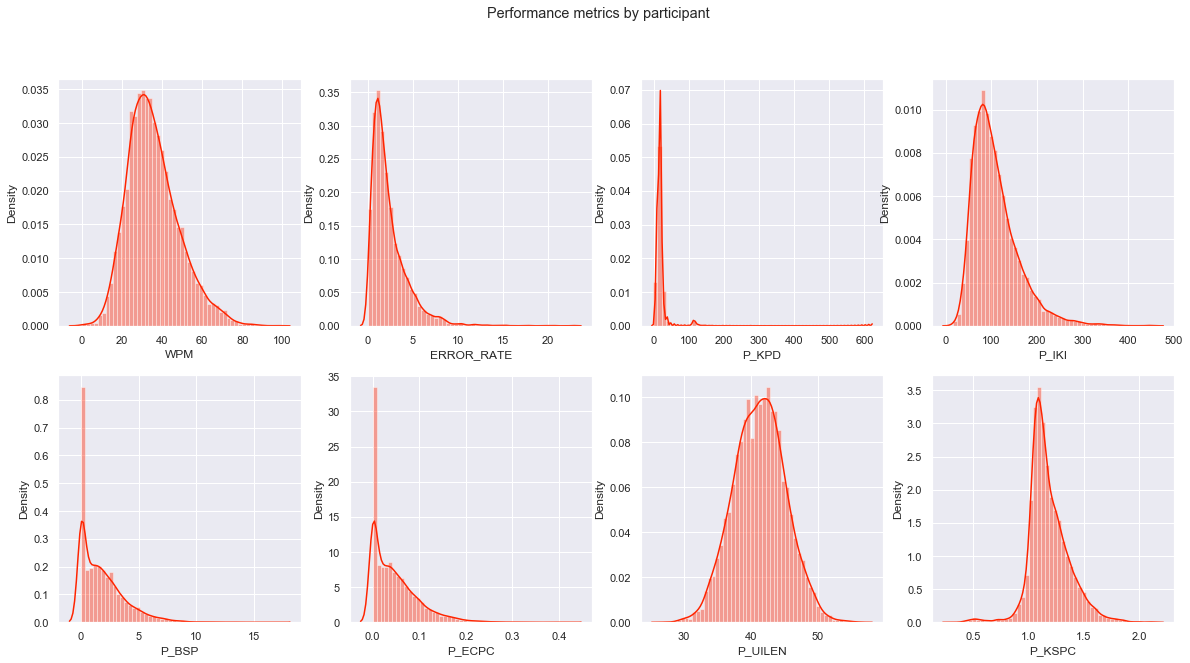

In [98]:
ROWS = 2
COLS = 4
fig, axs = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(20,10))
plt.suptitle('Performance metrics by participant')
for i in range(0,len(metrics)): 
    f = metrics[i]
    rown = int(i/COLS)
    coln = i%COLS
    if is_numeric_dtype(p_data[f]):
        sns.distplot(p_data[f], ax=axs[rown,coln])
        axs[rown,coln].set(ylabel="Density")
        

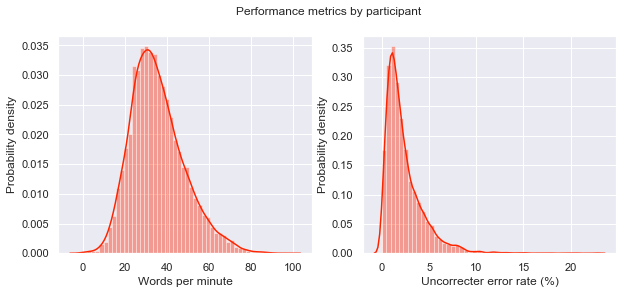

In [30]:
ROWS = 1
COLS = 2
fig, axs = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(10,4))
plt.suptitle('Performance metrics by participant')
paper_metrics = ['WPM', 'ERROR_RATE']

for i in range(0,len(paper_metrics)): 
    f = paper_metrics[i]
    rown = 0
    coln = i
    sns.distplot(p_data[f], ax=axs[i])
    axs[i].set(ylabel="Probability density")
axs[0].set(xlabel="Words per minute")
axs[1].set(xlabel="Uncorrecter error rate (%)")
#axs[2].set(xlabel="Inter-key interval")
        
plt.savefig('performance_measures.png', bbox_inches='tight')

#### Most of IKI density is below 50, as opposed to the 136m study where IKI was > 100

In [7]:
p_data[p_data.HAS_TAKEN_TYPING_COURSE==0].describe()

PARTICIPANT_ID     SCREEN_W     SCREEN_H          AGE  \
count     6131.000000  6131.000000  6131.000000  6131.000000   
mean     49731.848312   416.767575   700.723699    23.626815   
std      25780.078244   148.549432    90.805090     7.582651   
min        629.000000   320.000000   360.000000     7.000000   
25%      26940.500000   360.000000   640.000000    18.000000   
50%      50642.000000   375.000000   667.000000    22.000000   
75%      74679.500000   412.000000   736.000000    28.000000   
max      87240.000000  1112.000000  1280.000000    47.000000   

       HAS_TAKEN_TYPING_COURSE          WPM   ERROR_RATE        P_KPD  \
count                   6131.0  6131.000000  6131.000000  6131.000000   
mean                       0.0    35.610693     2.406212    20.580620   
std                        0.0    12.618462     2.048142    24.490373   
min                        0.0     0.216070     0.000000    -2.761036   
25%                        0.0    26.672003     1.020408    12.074169   
50%                        0.0    33.985582     1.812689    16.911645   
75%                        0.0    42.941934     3.246251    20.840621   
max                        0.0    97.418941    22.821577   618.656150   

             P_IKI        P_BSP       P_ECPC      P_UILEN       P_KSPC  
count  6131.000000  6131.000000  6131.000000  6131.000000  6131.000000  
mean    108.784085     1.828984     0.046879    41.267217     1.184426  
std      50.675701     1.905717     0.049548     3.814221     0.175818  
min      17.178851     0.000000     0.000000    27.266667     0.301364  
25%      72.584482     0.133333     0.003627    38.666667     1.074312  
50%      98.189466     1.400000     0.035008    41.266667     1.151005  
75%     132.406008     2.800000     0.072223    43.866667     1.276578  
max     446.154460    17.133333     0.421703    56.066667     2.087340

In [8]:
p_data[p_data.HAS_TAKEN_TYPING_COURSE==1].describe()

PARTICIPANT_ID     SCREEN_W     SCREEN_H          AGE  \
count     2325.000000  2325.000000  2325.000000  2325.000000   
mean     49628.126882   423.665806   701.793118    24.229677   
std      25273.169637   155.444445    97.867999     7.744726   
min        688.000000   320.000000   320.000000     7.000000   
25%      27556.000000   360.000000   640.000000    19.000000   
50%      51335.000000   375.000000   667.000000    23.000000   
75%      73667.000000   414.000000   736.000000    29.000000   
max      87241.000000  1024.000000  1031.000000    47.000000   

       HAS_TAKEN_TYPING_COURSE          WPM   ERROR_RATE        P_KPD  \
count                   2325.0  2325.000000  2325.000000  2325.000000   
mean                       1.0    35.839427     2.109839    17.810793   
std                        0.0    13.093296     1.937126    11.673578   
min                        1.0     2.362834     0.000000     2.182850   
25%                        1.0    26.695729     0.894188    12.682557   
50%                        1.0    33.902645     1.608579    16.990883   
75%                        1.0    43.394375     2.702703    20.818398   
max                        1.0    90.051768    20.649133   160.692343   

             P_IKI        P_BSP       P_ECPC      P_UILEN       P_KSPC  
count  2325.000000  2325.000000  2325.000000  2325.000000  2325.000000  
mean    107.206403     1.930409     0.049435    41.410810     1.179227  
std      49.939235     1.954798     0.050785     3.930527     0.188388  
min      16.032247     0.000000     0.000000    28.733333     0.420119  
25%      73.231361     0.266667     0.007018    38.733333     1.067938  
50%      95.145356     1.466667     0.037296    41.533333     1.141813  
75%     130.593775     2.866667     0.074371    44.000000     1.276165  
max     454.440839    13.533333     0.393483    54.866667     2.142867

## Test-section - level

In [99]:
# Load all valid participants 
TS_QUERY = 'SELECT * FROM FIRST_15_TEST_SECTIONS' 
ts_data = pd.read_sql_query(TS_QUERY, engine)

ts_data['INPUT_TIME_S'] = ts_data['INPUT_TIME'] / 1000

ts_metrics = ['TEST_SECTION_ID', 'PARTICIPANT_ID','INPUT_TIME_S', 'TS_KS', 
              'INPUT_LENGTH', 'ERROR_LEN', 'TS_UILEN', 'EDIT_DISTANCE', 
              'ERROR_RATE', 'WPM', 'TS_KPD', 'TS_IKI','TS_BSP', 'TS_ECPC',  'TS_KSPC']
ts_data[ts_metrics].tail(5)


TEST_SECTION_ID  PARTICIPANT_ID  INPUT_TIME_S  TS_KS  INPUT_LENGTH  \
126827           386163           87241        18.077     52            49   
126828           386166           87241         6.853     23            22   
126829           386167           87241        20.692     67            64   
126830           386170           87241        24.805     63            51   
126831           386173           87241        13.464     39            34   

        ERROR_LEN  TS_UILEN  EDIT_DISTANCE  ERROR_RATE        WPM      TS_KPD  \
126827         49        49              0         0.0  32.527521  144.750000   
126828         22        22              0         0.0  38.523274  132.913043   
126829         64        64              0         0.0  37.115794  127.791045   
126830         51        51              0         0.0  24.672445  132.460317   
126831         34        34              0         0.0  30.303030  127.230769   

            TS_IKI  TS_BSP   TS_ECPC   TS_KSPC  
126827  191.076923     0.0  0.000000  1.061224  
126828  162.260870     0.0  0.000000  1.045455  
126829  159.701493     1.0  0.015625  1.046875  
126830  184.031746     5.0  0.098039  1.235294  
126831  234.333333     2.0  0.058824  1.147059

/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


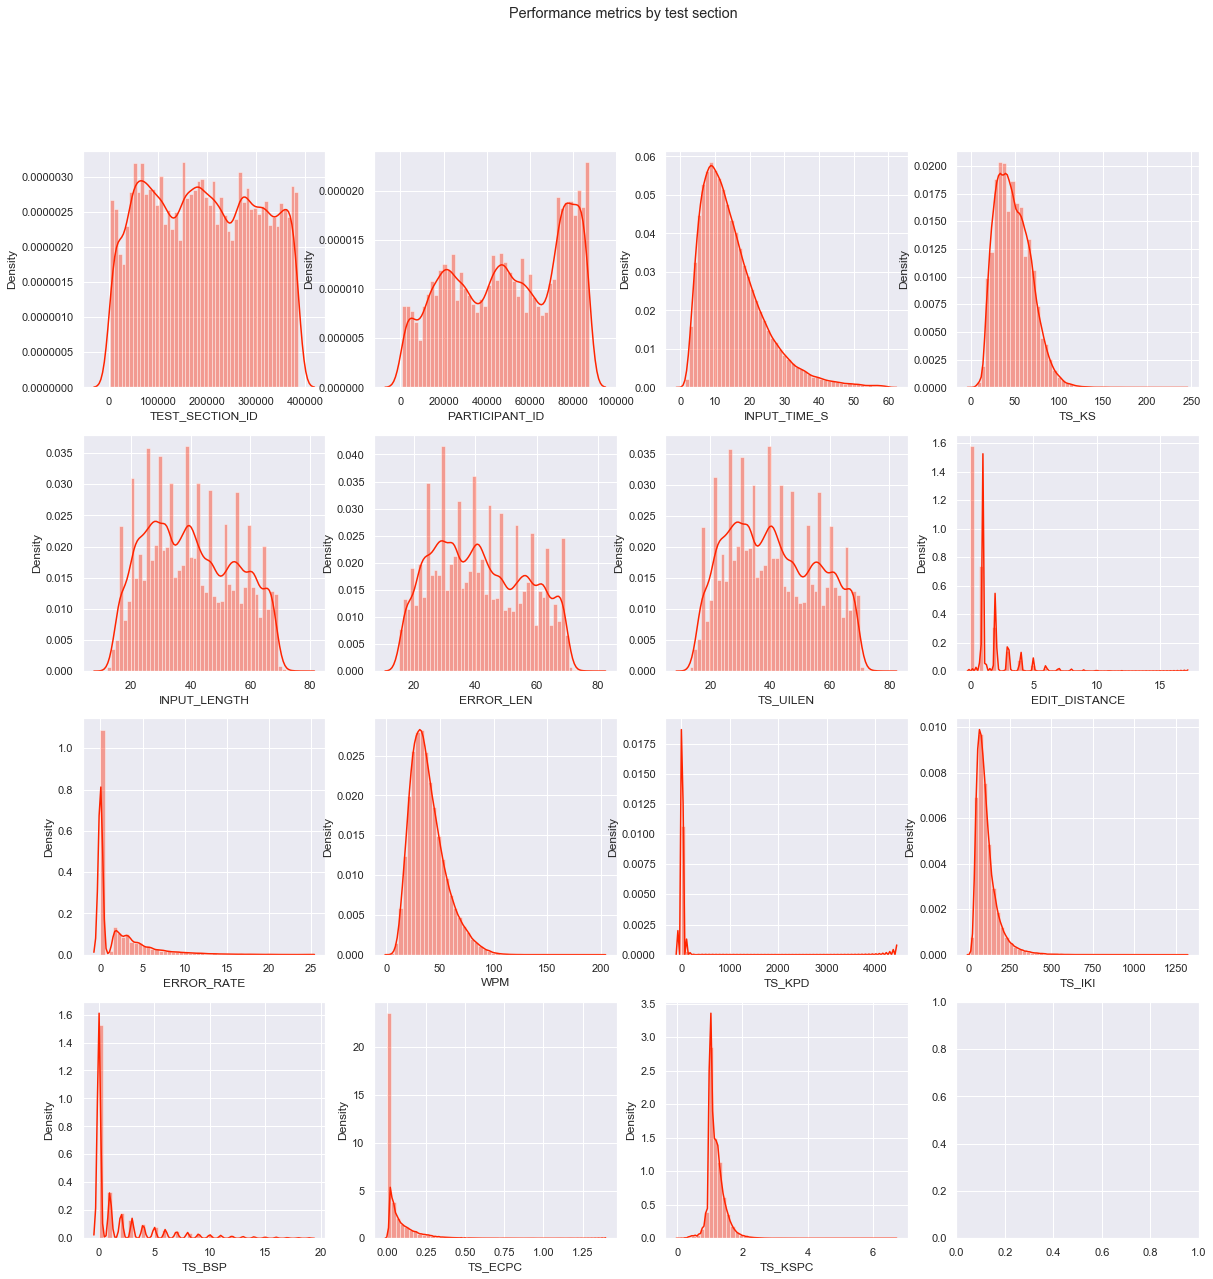

In [100]:
# Test sections where INPUT_TIME is less than a minute 
# and less than 20 backspaces registered
subset = (ts_data.INPUT_TIME_S < 60) & (ts_data.TS_BSP < 20) 

ROWS = 4
COLS = 4
fig, axs = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(20,20))
plt.suptitle('Performance metrics by test section')
for i in range(0,len(ts_metrics)): 
    f = ts_metrics[i]
    rown = int(i/COLS)
    coln = i%COLS
    if is_numeric_dtype(ts_data[subset][f]):
        sns.distplot(ts_data[subset][f], ax=axs[rown,coln])
        axs[rown,coln].set(ylabel="Density")

# Bivariate 

In [32]:
def categorize_age(x):
    
    if x > 0 and x < 10:
        return '0-9'
    elif x >= 10 and x < 20:
        return '10-19'
    elif x >= 20 and x < 30:
        return '20-29'
    elif x >= 30 and x < 40:
        return '30-39'
    elif x >= 40 and x < 50:
        return '40-49'
    elif x >= 50 and x < 60:
        return '50-59'
    elif x >= 60 and x < 70:
        return '60-69'
    elif x >= 70 and x < 80:
        return '70-79'
    elif x >= 80 and x < 90:
        return '80-89'
    elif x >= 90 and x < 100:
        return '90-99'
    else:
        return '100+'
    
p_data['AGE_CAT'] = p_data['AGE'].apply(lambda x: categorize_age(x))  

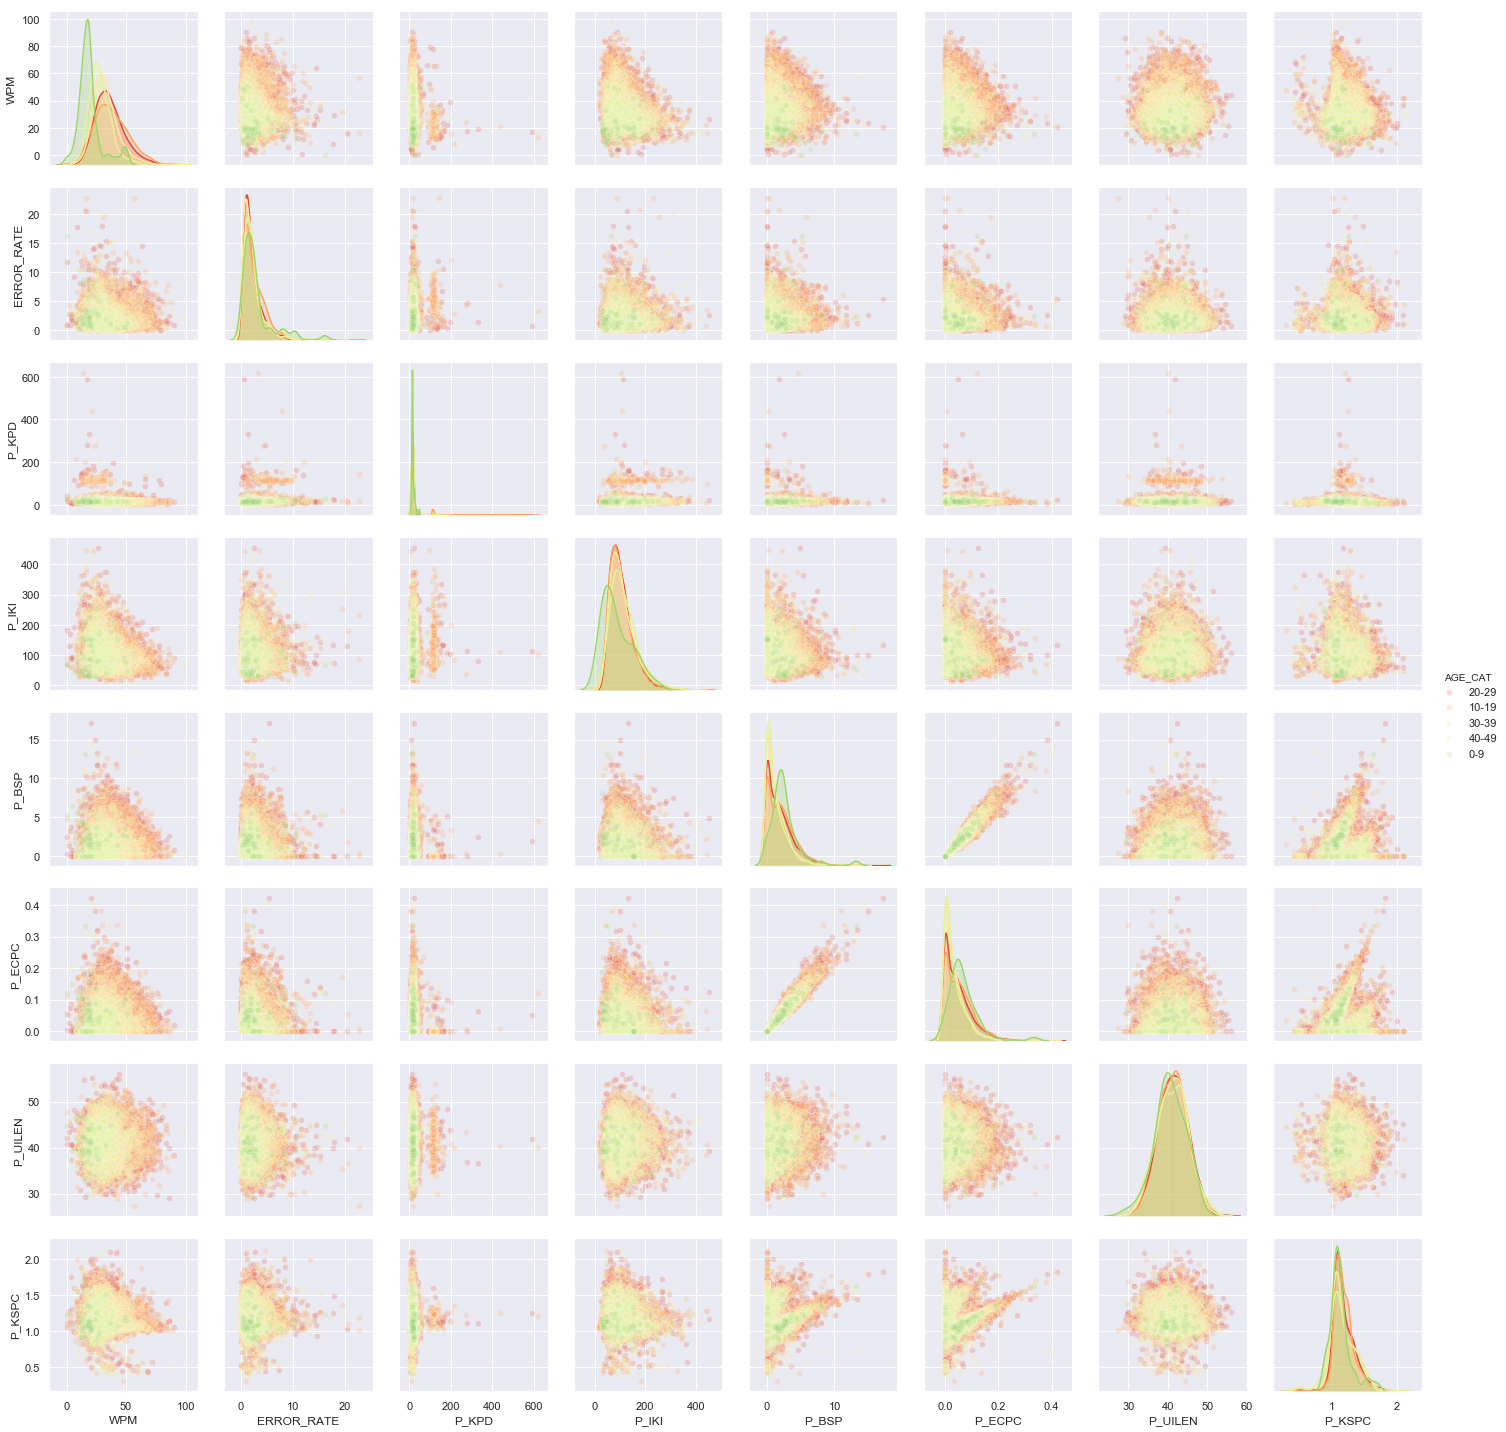

In [33]:
sns.set_palette('RdYlGn')
latent = 'AGE_CAT'
metrics = [latent, 'WPM', 'ERROR_RATE', 'P_KPD', 'P_IKI', 'P_BSP', 'P_ECPC', 'P_UILEN', 'P_KSPC']
sns.pairplot(p_data[metrics], hue=latent,  plot_kws={'alpha': 0.2})

## Bi-variate plots

### WPM vs Error Rate

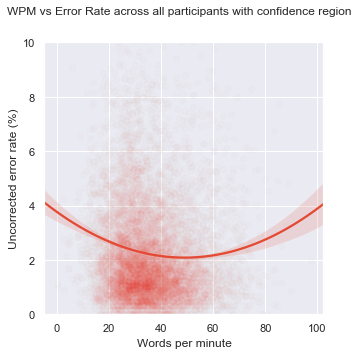

In [73]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
plt.suptitle('WPM vs Error Rate across all participants with confidence region')

sns.regplot(x='WPM', y='ERROR_RATE', data=p_data, order=2, scatter_kws={"alpha":0.01})
axs.set(xlabel="Words per minute")
axs.set(ylabel="Uncorrected error rate (%)")
axs.set(ylim=[0,10])

plt.savefig('wpm_vs_er.png', bbox_inches='tight')


### ECPC vs WPM , Error rate

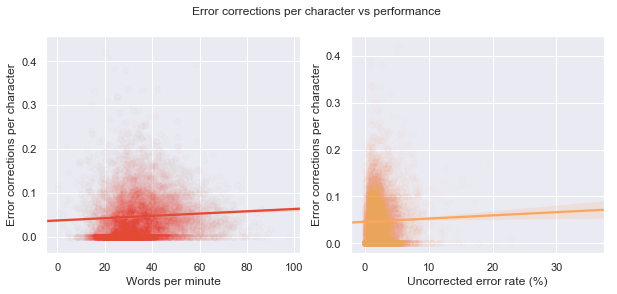

In [85]:
ROWS = 1
COLS = 2
fig, axs = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(10,4))
plt.suptitle('Error corrections per character vs performance')
paper_metrics = ['WPM', 'ERROR_RATE']

for i in range(0,len(paper_metrics)): 
    f = paper_metrics[i]
    rown = 0
    coln = i
    sns.regplot(x=p_data[f], y='P_ECPC', data=p_data, order=1, scatter_kws={"alpha":0.01}, ax=axs[i])
    axs[i].set(ylabel="Error corrections per character")

axs[0].set(xlabel="Words per minute")
axs[1].set(xlabel="Uncorrected error rate (%)")
       
plt.savefig('ecpc_vs_performance.png', bbox_inches='tight')



### KSPC vs WPM , Error rate

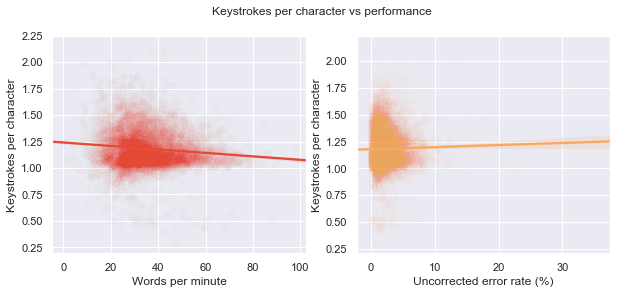

In [86]:
ROWS = 1
COLS = 2
fig, axs = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(10,4))
plt.suptitle('Keystrokes per character vs performance')
paper_metrics = ['WPM', 'ERROR_RATE']

for i in range(0,len(paper_metrics)): 
    f = paper_metrics[i]
    rown = 0
    coln = i
    sns.regplot(x=p_data[f], y='P_KSPC', data=p_data, order=1, scatter_kws={"alpha":0.01}, ax=axs[i])
    axs[i].set(ylabel="Keystrokes per character")

axs[0].set(xlabel="Words per minute")
axs[1].set(xlabel="Uncorrected error rate (%)")
       
plt.savefig('ecpc_vs_performance.png', bbox_inches='tight')

## Distinguishing fastest and slowest typists

In [88]:
p_data[['WPM']].describe()

WPM
count  8456.000000
mean     35.673584
std      12.750411
min       0.216070
25%      26.677234
50%      33.963899
75%      43.039018
max      97.418941

In [100]:
fast_th = np.mean(p_data.WPM) + np.std(p_data.WPM)/2
slow_th = np.mean(p_data.WPM) - np.std(p_data.WPM)/2

In [112]:
fast_th

42.048412073065336

In [113]:
slow_th

29.298755148059925

In [101]:
p_data['fast']=p_data.WPM.apply(lambda x: 1 if x>fast_th else 0)
p_data['slow']=p_data.WPM.apply(lambda x: 1 if x<slow_th else 0)

/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


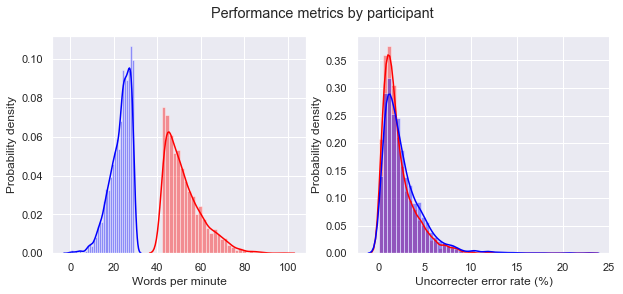

In [103]:
ROWS = 1
COLS = 2
fig, axs = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(10,4))
plt.suptitle('Performance metrics by participant')
paper_metrics = ['WPM', 'ERROR_RATE']

for i in range(0,len(paper_metrics)): 
    f = paper_metrics[i]
    rown = 0
    coln = i
    sns.distplot(p_data[p_data['fast']==1][f], ax=axs[i], color='red', label='fast')
    sns.distplot(p_data[p_data['slow']==1][f], ax=axs[i], color='blue', label='slow')
    axs[i].set(ylabel="Probability density")
axs[0].set(xlabel="Words per minute")
axs[1].set(xlabel="Uncorrecter error rate (%)")
#axs[2].set(xlabel="Inter-key interval")
        
plt.savefig('performance_measures.png', bbox_inches='tight')

/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


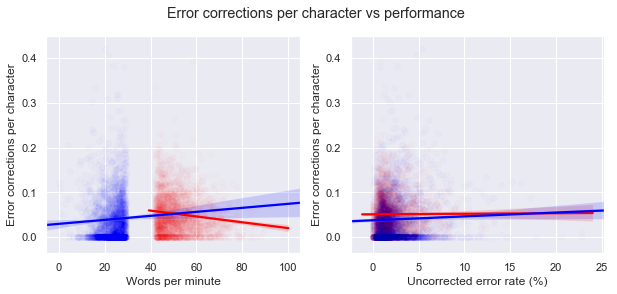

In [107]:
ROWS = 1
COLS = 2
fig, axs = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(10,4))
plt.suptitle('Error corrections per character vs performance')
paper_metrics = ['WPM', 'ERROR_RATE']

for i in range(0,len(paper_metrics)): 
    f = paper_metrics[i]
    rown = 0
    coln = i
    sns.regplot(x=p_data[p_data['fast']==1][f], y=p_data[p_data['fast']==1]['P_ECPC'], data=p_data[p_data['fast']==1], order=1, color='red', scatter_kws={"alpha":0.01, "color":'red'}, ax=axs[i])
    sns.regplot(x=p_data[p_data['slow']==1][f], y=p_data[p_data['slow']==1]['P_ECPC'], data=p_data[p_data['fast']==1], order=1, color='blue', scatter_kws={"alpha":0.01, "color":'blue'}, ax=axs[i])
    axs[i].set(ylabel="Error corrections per character")

axs[0].set(xlabel="Words per minute")
axs[1].set(xlabel="Uncorrected error rate (%)")
       
plt.savefig('ecpc_vs_performance.png', bbox_inches='tight')



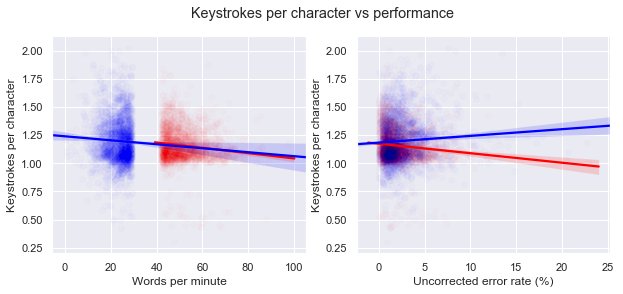

In [108]:
ROWS = 1
COLS = 2
fig, axs = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(10,4))
plt.suptitle('Keystrokes per character vs performance')
paper_metrics = ['WPM', 'ERROR_RATE']

for i in range(0,len(paper_metrics)): 
    f = paper_metrics[i]
    rown = 0
    coln = i
    sns.regplot(x=p_data[p_data['fast']==1][f], y=p_data[p_data['fast']==1]['P_KSPC'], data=p_data[p_data['fast']==1], order=1, color='red', scatter_kws={"alpha":0.01, "color":'red'}, ax=axs[i])
    sns.regplot(x=p_data[p_data['slow']==1][f], y=p_data[p_data['slow']==1]['P_KSPC'], data=p_data[p_data['fast']==1], order=1, color='blue', scatter_kws={"alpha":0.01, "color":'blue'}, ax=axs[i])
    axs[i].set(ylabel="Keystrokes per character")

axs[0].set(xlabel="Words per minute")
axs[1].set(xlabel="Uncorrected error rate (%)")
       
plt.savefig('ecpc_vs_performance.png', bbox_inches='tight')

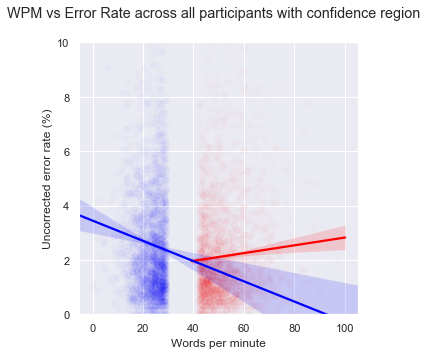

In [111]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
plt.suptitle('WPM vs Error Rate across all participants with confidence region')

sns.regplot(x='WPM', y='ERROR_RATE', data=p_data[p_data['fast']==1], color='red', order=1, scatter_kws={"alpha":0.01, "color":'red'})
sns.regplot(x='WPM', y='ERROR_RATE', data=p_data[p_data['slow']==1], color='blue', order=1, scatter_kws={"alpha":0.01, "color":'blue'})

axs.set(xlabel="Words per minute")
axs.set(ylabel="Uncorrected error rate (%)")
axs.set(ylim=[0,10])

plt.savefig('wpm_vs_er.png', bbox_inches='tight')